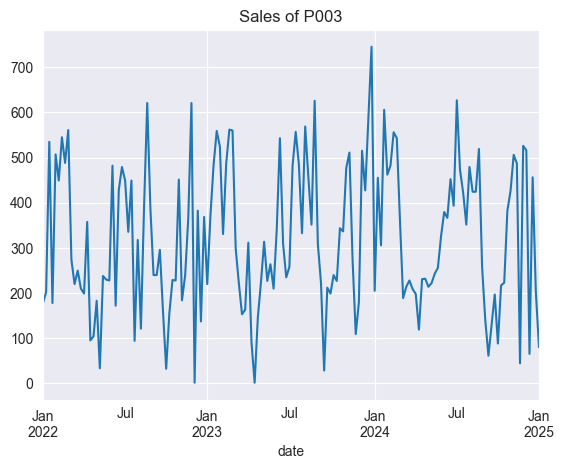

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

# Load and prepare the data
df = pd.read_csv('../data/retail_demand_dataset.csv', parse_dates=['date'], index_col='date')
one_product = df[df['product_id'] == 'P003']['units_sold']
series = one_product.resample('W').sum()

# Split into train and test sets
train = series[:-52]  # First two years for training
test = series[-52:]   # Last year for testing

# Plot
series.plot(kind='line', xlabel='date', title="Sales of P003")
plt.show()

# Testing for Stationarity

In [21]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is not stationary - differencing required")
        return False

print("Original Series:")
is_stationary = check_stationarity(train)

Original Series:
ADF Statistic: -7.1201
p-value: 0.0000
Critical Values:
	1%: -3.4942
	5%: -2.8895
	10%: -2.5817
Series is stationary


If the series isn't stationary (p-value > 0.05), we difference it:

In [22]:
if is_stationary:
    train_diff = train
else:
    # First difference if needed
    train_diff = train.diff().dropna()
    print("After First Differencing:")
    check_stationarity(train_diff)

# Identifying Seasonality and Model Parameters

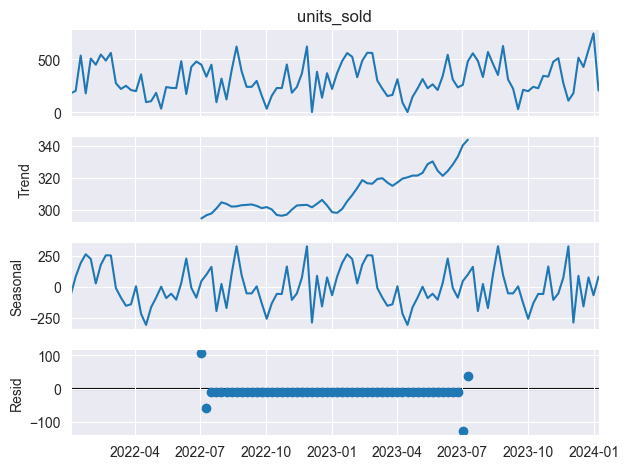

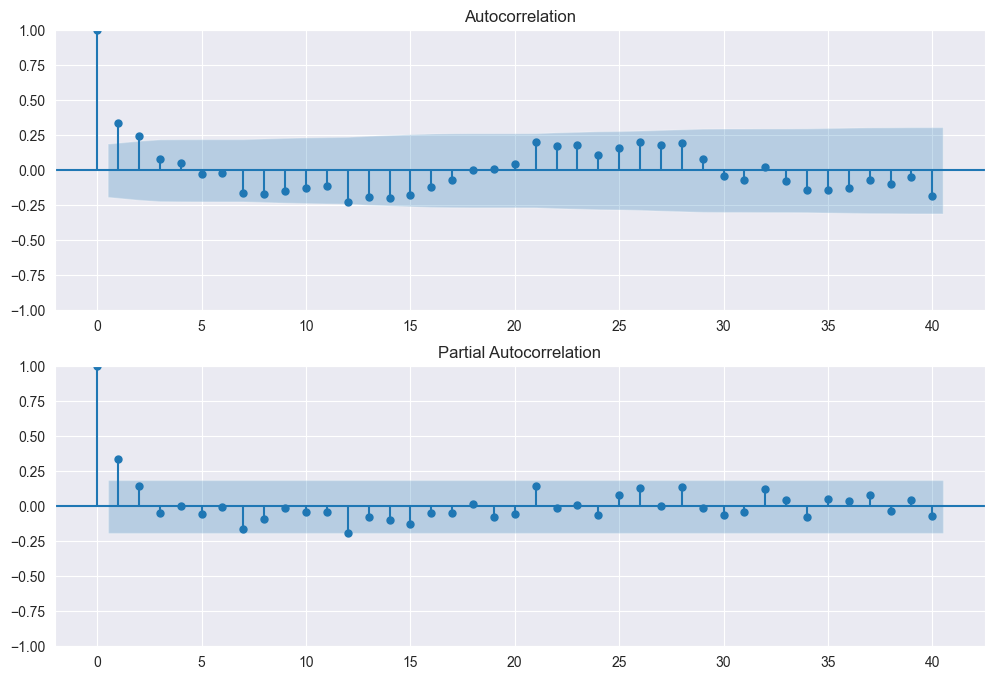

In [23]:
# Seasonal decomposition
decomposition = seasonal_decompose(train, model='additive')
decomposition.plot()
plt.show()

# ACF and PACF plots to identify AR and MA terms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_diff, ax=ax1, lags=40)
plot_pacf(train_diff, ax=ax2, lags=40)
plt.show()

# Model 1: Exponential Smoothing (ETS)

In [30]:
# Fit Exponential Smoothing model (assuming additive seasonality)
ets_model = ets.ETSModel(train, trend='add', seasonal='add', seasonal_periods=52)
ets_fit = ets_model.fit()

# Generate a forecast for the test period
ets_forecast = ets_fit.forecast(len(test))
print(f'ETS AIC: {ets_fit.aic:.2f}, MAE: {ets_fit.mae:.2f} and MSE: {ets_fit.mse:.2f}')

ETS AIC: 1421.84, MAE: 90.39 and MSE: 13112.53


# Model 2: ARIMA

In [64]:
# Fit ARIMA model based on our analysis
arima_model = ARIMA(train_diff, order=(3, 0, 1))
arima_fit = arima_model.fit()

# Generate forecast
arima_forecast = arima_fit.forecast(len(test))
print(f'ETS AIC: {arima_fit.aic:.2f}, MAE: {arima_fit.mae:.2f} and MSE: {arima_fit.mse:.2f}')

ETS AIC: 1376.62, MAE: 125.64 and MSE: 22824.08


# Model Diagnostics


--- ARIMA Model Diagnostics ---


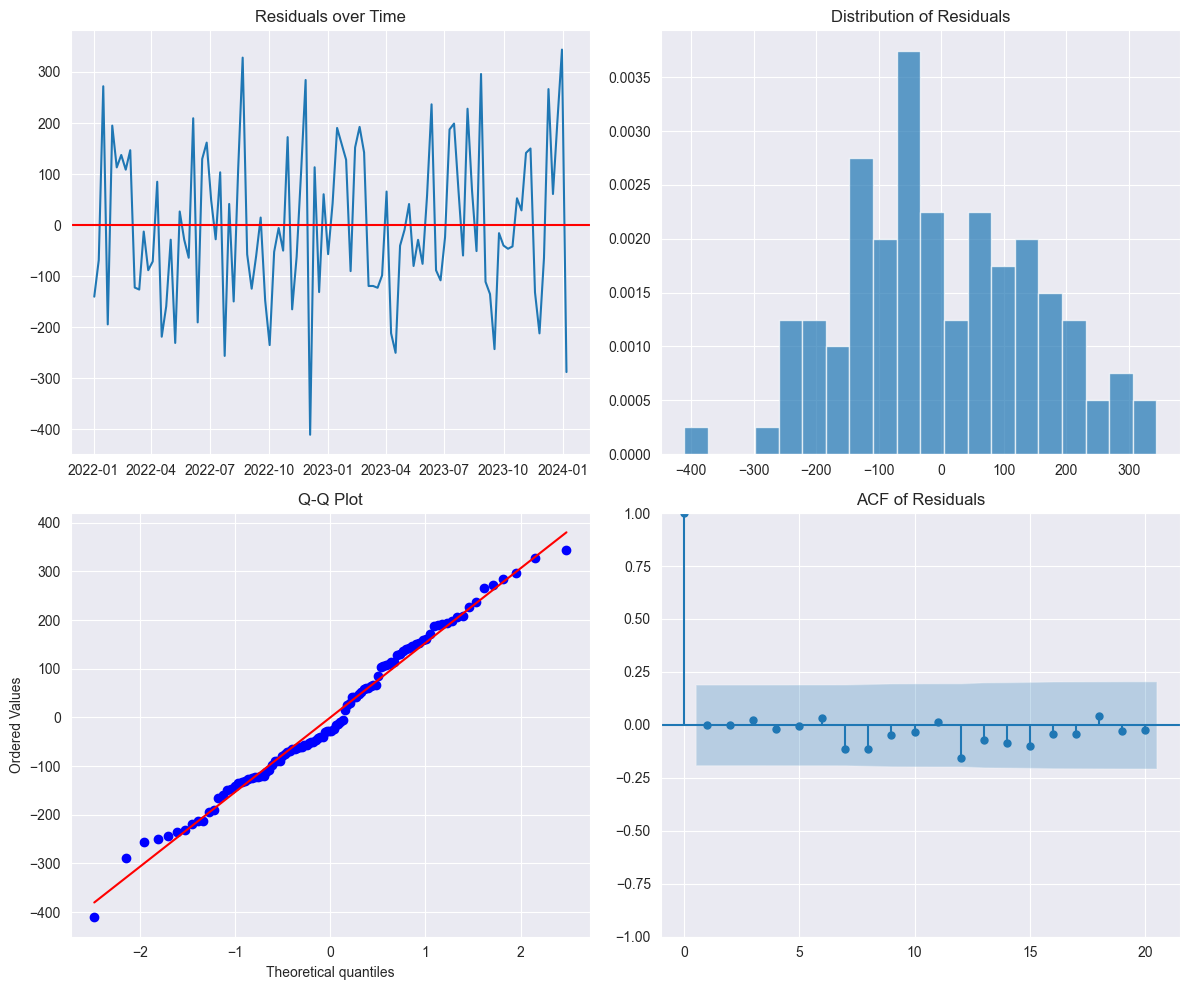

Ljung-Box Test p-value: 0.9628
Residuals are independent (good!)


In [65]:
def diagnose_model(model_fit, model_name):
    print(f"\n--- {model_name} Diagnostics ---")

    # Get residuals
    residuals = model_fit.resid.dropna()

    # Plot residuals
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals over time
    axes[0,0].plot(residuals)
    axes[0,0].set_title('Residuals over Time')
    axes[0,0].axhline(y=0, color='r', linestyle='-')

    # Distribution of residuals
    axes[0,1].hist(residuals, bins=20, density=True, alpha=0.7)
    axes[0,1].set_title('Distribution of Residuals')

    # Q-Q plot for normality
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')

    # ACF of residuals
    plot_acf(residuals, ax=axes[1,1], lags=20)
    axes[1,1].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

    # Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"Ljung-Box Test p-value: {lb_test['lb_pvalue'].iloc[-1]:.4f}")
    if lb_test['lb_pvalue'].iloc[-1] > 0.05:
        print("Residuals are independent (good!)")
    else:
        print("Residuals show autocorrelation (problem!)")

# Run diagnostics
diagnose_model(arima_fit, "ARIMA Model")

# Evaluation

ETS Model MAE: 149.38
ARIMA Model MAE: 138.77


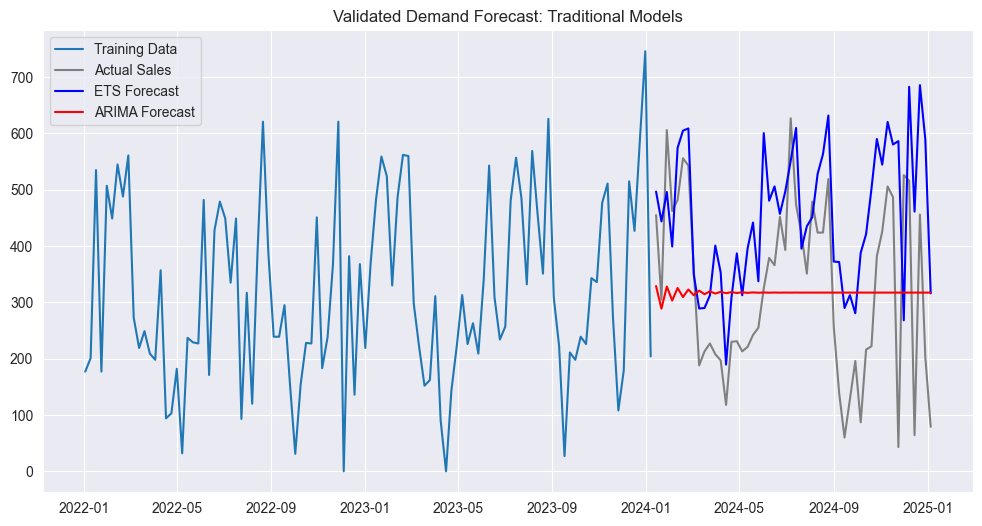

In [66]:
ets_mae = mean_absolute_error(test, ets_forecast)
arima_mae = mean_absolute_error(test, arima_forecast)

print(f"ETS Model MAE: {ets_mae:.2f}")
print(f"ARIMA Model MAE: {arima_mae:.2f}")

# Visualize the final forecasts
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='grey')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Validated Demand Forecast: Traditional Models')
plt.show()